In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from timm import create_model
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from torch.nn.functional import silu

In [ ]:
# Configuration
DATA_DIR = '/content/drive/MyDrive/PlantVillage'
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_EPOCHS = 30
NUM_CLASSES = 10
LEARNING_RATE = 3e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enhanced Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE+64, IMG_SIZE+64)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 2.0))
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load Dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)

# Split dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Fix transforms
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform


In [ ]:
# DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Enhanced Hybrid Model
class PlantDiseaseClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()

        # Swin backbone
        self.backbone = create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=True,
            num_classes=0,
            features_only=True
        )

        # Enhanced Convolutional head
        self.conv_head = nn.Sequential(
            nn.Conv2d(768, 512, 1),
            nn.BatchNorm2d(512),
            nn.SiLU(),
            nn.Dropout2d(0.15),
            nn.Conv2d(512, 384, 3, padding=1, groups=128),
            nn.BatchNorm2d(384),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(384, 256),
            nn.SiLU(),
            nn.Dropout(0.1)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)[-1]
        features = features.permute(0, 3, 1, 2)
        features = self.conv_head(features)
        return self.classifier(features)

# Initialize model
model = PlantDiseaseClassifier(NUM_CLASSES).to(DEVICE)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
# Weight initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

# Enhanced Loss and optimizer
class_weights = torch.tensor([1.0, 1.2, 1.1, 1.0, 1.3, 1.0, 1.1, 1.0, 1.2, 1.0]).to(DEVICE)
criterion = nn.CrossEntropyLoss(
    label_smoothing=0.05,
    weight=class_weights
)

optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.01
)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE*3,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=10000.0
)

scaler = GradScaler()


<ipython-input-6-068554fc74e8>:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Training loop
best_val_acc = 0.0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    torch.backends.cudnn.benchmark = True

    # Learning rate warmup
    if epoch < 5:
        for param_group in optimizer.param_groups:
            param_group['lr'] = LEARNING_RATE * (epoch + 1) / 5

    for images, labels in train_loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        # MixUp augmentation
        lam = np.random.beta(0.4, 0.4) if epoch < NUM_EPOCHS//2 else 1.0
        if lam < 1.0:
            indices = torch.randperm(images.size(0))
            mixed_images = lam * images + (1 - lam) * images[indices]
            mixed_labels = labels[indices]

            optimizer.zero_grad(set_to_none=True)

            # Updated autocast context
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(mixed_images)
                loss = lam * criterion(outputs, labels) + (1 - lam) * criterion(outputs, mixed_labels)
        else:
            optimizer.zero_grad(set_to_none=True)

            # Updated autocast context
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.float().max(1)  # Explicit conversion to float
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            # Validation doesn't need autocast
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Calculate metrics
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_acc = correct / total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_model.pth')

    print(f'Epoch {epoch+1}/{NUM_EPOCHS} | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Train Acc: {train_acc:.4f} | '
          f'Val Acc: {val_acc:.4f} | '
          f'LR: {optimizer.param_groups[0]["lr"]:.2e}')


Epoch 1/30 | Train Loss: 1.9683 | Val Loss: 1.3752 | Train Acc: 0.2485 | Val Acc: 0.6112 | LR: 6.21e-05
Epoch 2/30 | Train Loss: 1.4881 | Val Loss: 1.2271 | Train Acc: 0.3893 | Val Acc: 0.6669 | LR: 1.37e-04
Epoch 3/30 | Train Loss: 1.4054 | Val Loss: 1.0587 | Train Acc: 0.4486 | Val Acc: 0.7077 | LR: 2.52e-04
Epoch 4/30 | Train Loss: 1.2806 | Val Loss: 0.8078 | Train Acc: 0.4589 | Val Acc: 0.8127 | LR: 3.93e-04
Epoch 5/30 | Train Loss: 1.1961 | Val Loss: 1.0732 | Train Acc: 0.4449 | Val Acc: 0.6865 | LR: 5.43e-04
Epoch 6/30 | Train Loss: 1.1770 | Val Loss: 0.7303 | Train Acc: 0.4959 | Val Acc: 0.8526 | LR: 6.84e-04
Epoch 7/30 | Train Loss: 1.1164 | Val Loss: 0.6867 | Train Acc: 0.4948 | Val Acc: 0.8501 | LR: 7.99e-04
Epoch 8/30 | Train Loss: 1.0955 | Val Loss: 0.6584 | Train Acc: 0.4802 | Val Acc: 0.8668 | LR: 8.74e-04
Epoch 9/30 | Train Loss: 1.0557 | Val Loss: 0.6583 | Train Acc: 0.4810 | Val Acc: 0.8622 | LR: 9.00e-04
Epoch 10/30 | Train Loss: 0.9875 | Val Loss: 0.6000 | Train Acc:

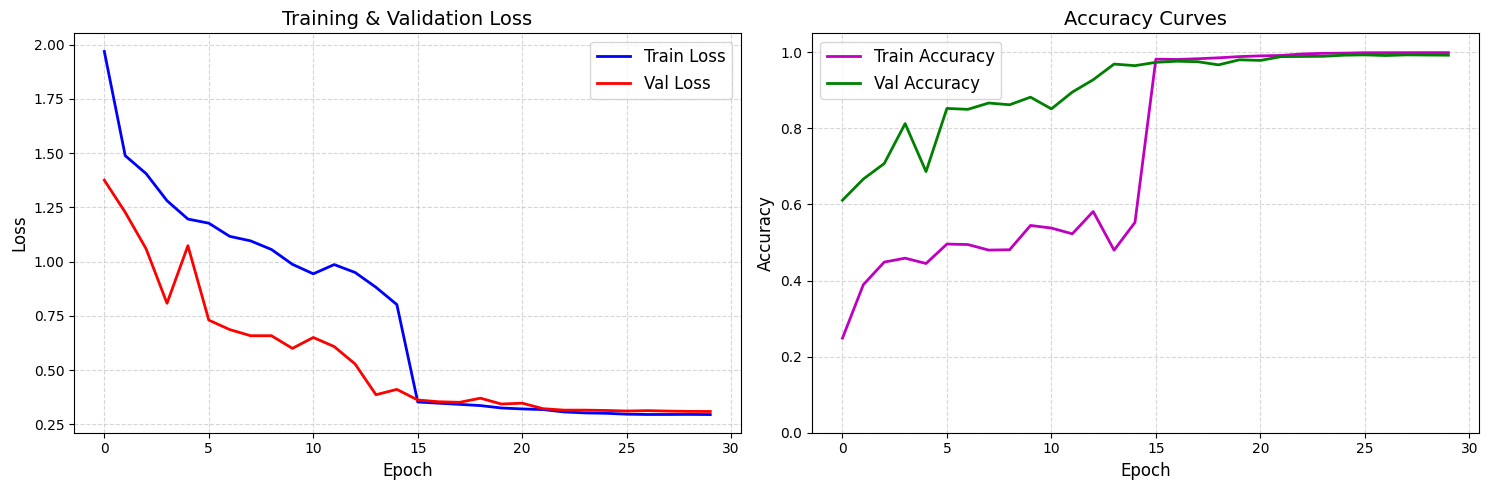

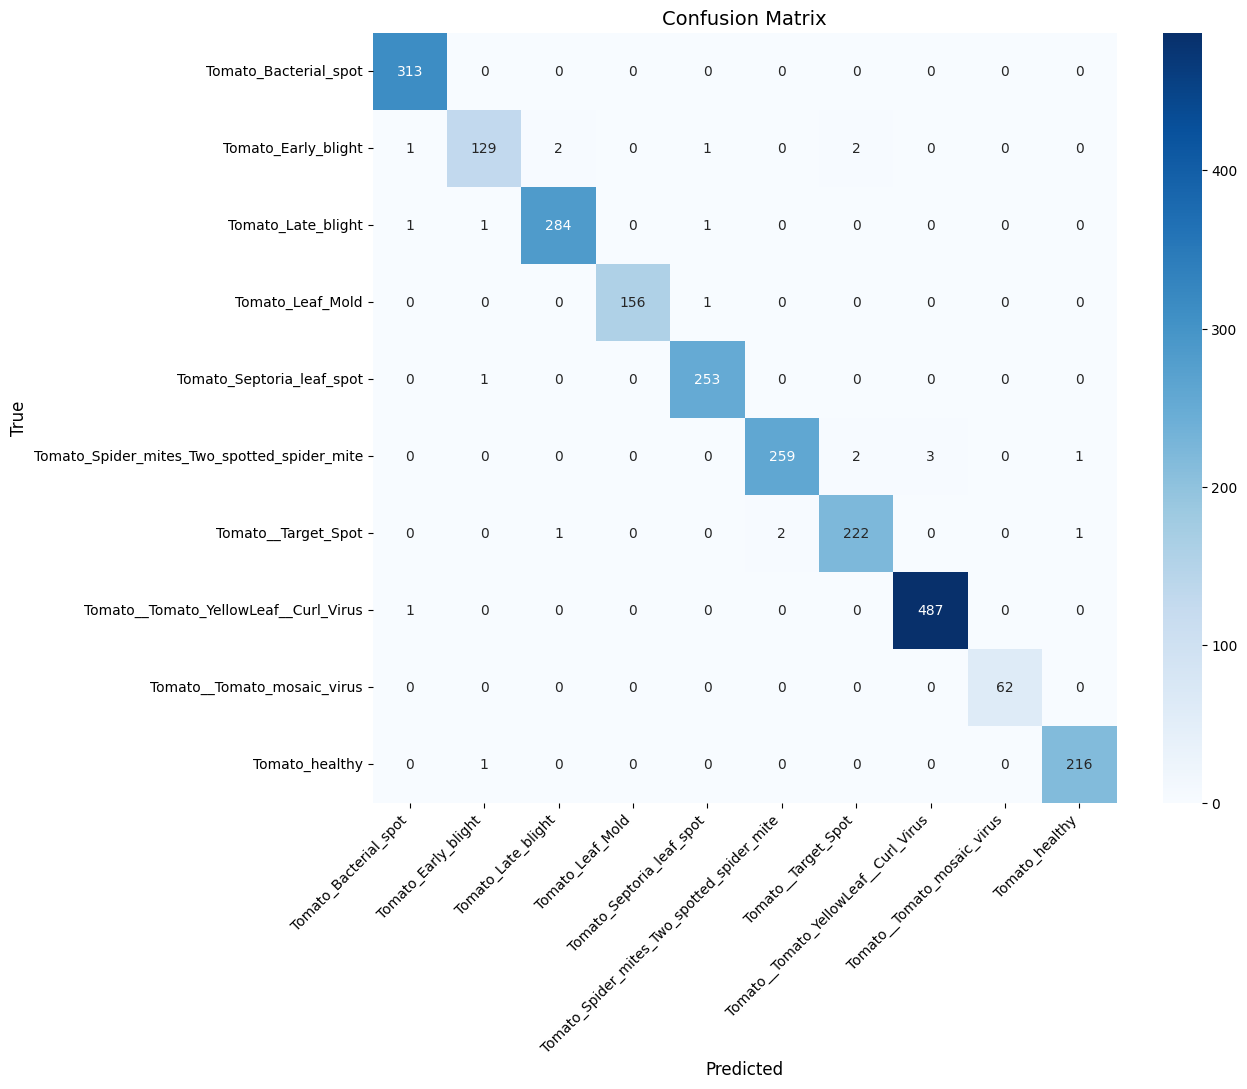


CLASSIFICATION REPORT:
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot     0.9905    1.0000    0.9952       313
                        Tomato_Early_blight     0.9773    0.9556    0.9663       135
                         Tomato_Late_blight     0.9895    0.9895    0.9895       287
                           Tomato_Leaf_Mold     1.0000    0.9936    0.9968       157
                  Tomato_Septoria_leaf_spot     0.9883    0.9961    0.9922       254
Tomato_Spider_mites_Two_spotted_spider_mite     0.9923    0.9774    0.9848       265
                        Tomato__Target_Spot     0.9823    0.9823    0.9823       226
      Tomato__Tomato_YellowLeaf__Curl_Virus     0.9939    0.9980    0.9959       488
                Tomato__Tomato_mosaic_virus     1.0000    1.0000    1.0000        62
                             Tomato_healthy     0.9908    0.9954    0.9931       217

                                   accu

In [ ]:
# Visualization Section
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', linewidth=2, label='Train Loss')
plt.plot(val_losses, 'r-', linewidth=2, label='Val Loss')
plt.title('Training & Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'm-', linewidth=2, label='Train Accuracy')
plt.plot(val_accuracies, 'g-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.05)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Confusion Matrix and Classification Report
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = full_dataset.classes

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(all_labels, all_preds,
                          target_names=class_names,
                          digits=4))
print("="*60)

# Test Accuracy
test_acc = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_preds)
print(f'\nFinal Test Accuracy: {test_acc:.2f}%')


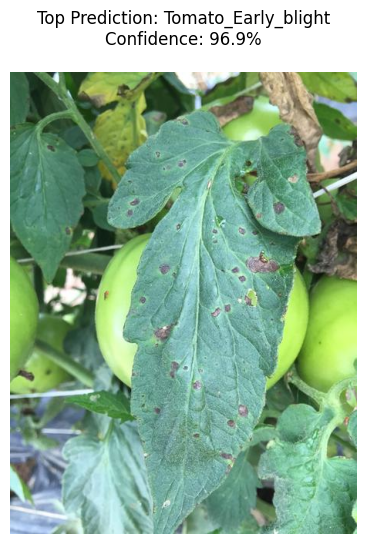


🔍 TOP 3 PREDICTIONS:
1. Tomato_Early_blight: 96.9%
2. Tomato_Septoria_leaf_spot: 0.4%
3. Tomato_Yellow_Leaf_Curl_Virus: 0.4%

✅ Final Prediction: Tomato_Early_blight (96.9% confidence)


In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import os

def predict_tomato_disease(image_path, model_path='best_model.pth'):
    """Predict tomato disease from an image with robust error handling"""
    try:
        # 1. Verify image exists
        if not os.path.exists(image_path):
            available_files = [f for f in os.listdir('/content') if f.lower().endswith(('.png','.jpg','.jpeg'))]
            raise FileNotFoundError(
                f"Image not found at: {image_path}\n"
                f"Available images: {available_files or 'None found'}"
            )

        # 2. Initialize model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = PlantDiseaseClassifier(NUM_CLASSES).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
        model.eval()

        # 3. Preprocess image
        transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        # 4. Predict
        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.nn.functional.softmax(output[0], dim=0)

        # 5. Prepare results
        class_names = [
            'Tomato_Bacterial_spot',
            'Tomato_Early_blight',
            'Tomato_Late_blight',
            'Tomato_Leaf_Mold',
            'Tomato_Septoria_leaf_spot',
            'Tomato_Spider_mites',
            'Tomato_Target_Spot',
            'Tomato_Yellow_Leaf_Curl_Virus',
            'Tomato_mosaic_virus',
            'Tomato_healthy'
        ]
        top3_prob, top3_class = probs.topk(3)

        # 6. Display results
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Top Prediction: {class_names[top3_class[0]]}\nConfidence: {top3_prob[0].item()*100:.1f}%",
                 pad=20, fontsize=12)
        plt.axis('off')
        plt.show()

        print("\n🔍 TOP 3 PREDICTIONS:")
        for i in range(3):
            print(f"{i+1}. {class_names[top3_class[i]]}: {top3_prob[i].item()*100:.1f}%")

        return {
            'prediction': class_names[top3_class[0]],
            'confidence': float(top3_prob[0].item()*100),
            'all_predictions': [
                (class_names[i], float(prob.item()*100))
                for i, prob in zip(top3_class, top3_prob)
            ]
        }

    except Exception as e:
        print(f"\n ERROR: {str(e)}")
        print("\n TROUBLESHOOTING:")
        print("1. Click the  icon and upload your image")
        print("2. Use exact filename (case-sensitive)")
        print("3. Supported formats: .jpg, .png, .jpeg")
        print(f"4. Current files in /content: {os.listdir('/content')}")
        return None



# OPTION 2: For your uploaded image (recommended)
result = predict_tomato_disease("/content/test1.jpeg")

if result:
    print(f"\n✅ Final Prediction: {result['prediction']} ({result['confidence']:.1f}% confidence)")